nr of spikes: 0


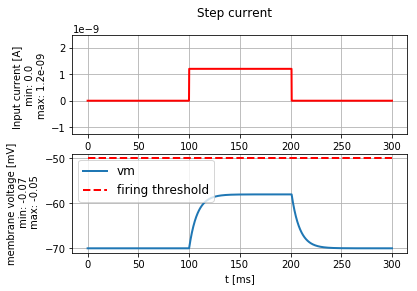

nr of spikes: 5


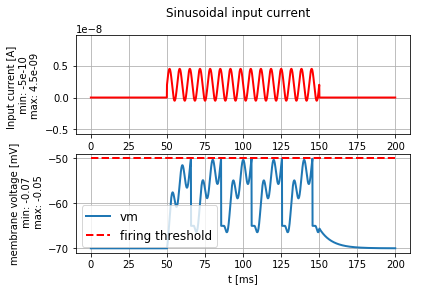

Resting potential: -0.07
Reset voltage: -0.065
Firing threshold: -0.05
Membrane resistance: 10000000.0
Membrane time-scale: 0.008
Absolute refractory period: 0.002


In [1]:
%matplotlib inline
import brian2 as b2
import matplotlib.pyplot as plt
import numpy as np
from neurodynex.leaky_integrate_and_fire import LIF
from neurodynex.tools import input_factory, plot_tools


LIF.getting_started()
LIF.print_default_parameters()

In [2]:
V_REST = -70*b2.mV
V_RESET = -65*b2.mV
FIRING_THRESHOLD = -50*b2.mV
MEMBRANE_RESISTANCE = 10. * b2.Mohm
MEMBRANE_TIME_SCALE = 8. * b2.ms
ABSOLUTE_REFRACTORY_PERIOD = 2.0 * b2.ms

In [3]:
i_min = (LIF.FIRING_THRESHOLD - LIF.V_REST)/(LIF.MEMBRANE_RESISTANCE)
print("current to fire spike: {}".format(i_min))

current to fire spike: 2e-09


nr of spikes: 4


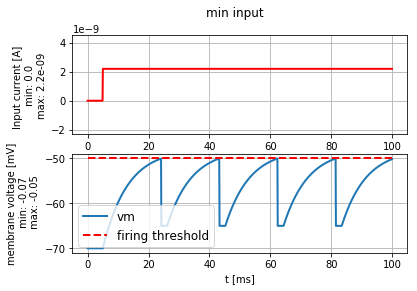

In [4]:
step_current = input_factory.get_step_current(t_start=5,t_end=100,unit_time=b2.ms,amplitude = i_min*1.1)

(state_monitor,spike_monitor) = LIF.simulate_LIF_neuron(input_current=step_current, simulation_time = 100 * b2.ms)

plot_tools.plot_voltage_and_current_traces(
state_monitor, step_current, title="min input", firing_threshold=LIF.FIRING_THRESHOLD)
print("nr of spikes: {}".format(spike_monitor.count[0]))  # should be 0

FI Curve

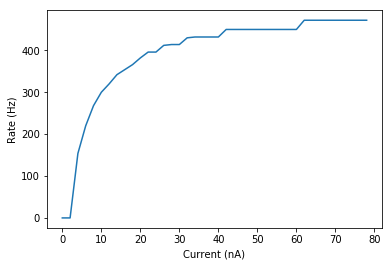

In [5]:
currents = np.arange(0,80,2) * b2.namp
spikes = np.zeros(np.shape(currents))
for i,cur in enumerate(currents):
    step_current = input_factory.get_step_current(t_start=5,t_end=500,unit_time=b2.ms,amplitude = cur)
    (state_monitor,spike_monitor) = LIF.simulate_LIF_neuron(input_current=step_current, simulation_time = 500 * b2.ms)
    spikes[i] = spike_monitor.count[0]*2
    
plt.plot(currents * 1e9,spikes)
plt.xlabel('Current (nA)')
plt.ylabel('Rate (Hz)')
plt.show()
plt.close()


## Estimating LIF parameters

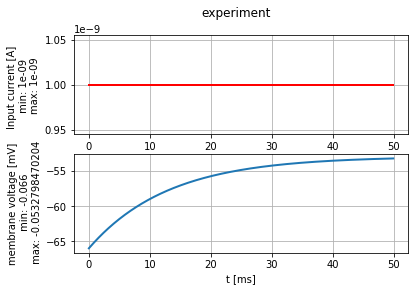

In [60]:
# get a random parameter. provide a random seed to have a reproducible experiment
random_parameters = LIF.get_random_param_set(random_seed=432)

# define your test current
test_current = input_factory.get_step_current(
    t_start=0, t_end=50, unit_time=b2.ms, amplitude= 1 * b2.namp)

# probe the neuron. pass the test current AND the random params to the function
state_monitor, spike_monitor = LIF.simulate_random_neuron(test_current, random_parameters)

# plot
plot_tools.plot_voltage_and_current_traces(state_monitor, test_current, title="experiment");

Firing threshold = -38 mV  
Reset voltage = -63 mV  
Resting potential = -66 mV  
Membrane resistance = 13 Mohm  
Membrane time scale = 13 ms (1/e)  
Refactory period = 6 ms

In [61]:
# print the parameters to the console and compare with your estimates
LIF.print_obfuscated_parameters(random_parameters)

Resting potential: -0.066
Reset voltage: -0.063
Firing threshold: -0.038
Membrane resistance: 13000000.0
Membrane time-scale: 0.013
Absolute refractory period: 0.005


## Subthreshold response

nr of spikes: 0


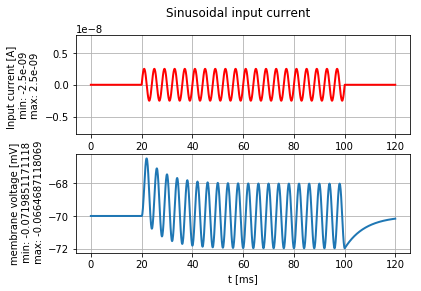

In [70]:
# note the higher resolution when discretizing the sine wave: we specify unit_time=0.1 * b2.ms
sinusoidal_current = input_factory.get_sinusoidal_current(200, 1000, unit_time=0.1 * b2.ms,
                                            amplitude= 2.5 * b2.namp, frequency=250*b2.Hz,
                                            direct_current=0. * b2.namp)

# run the LIF model. By setting the firing threshold to to a high value, we make sure to stay in the linear (non spiking) regime.
(state_monitor, spike_monitor) = LIF.simulate_LIF_neuron(input_current=sinusoidal_current, simulation_time = 120 * b2.ms, firing_threshold=0*b2.mV)

# plot the membrane voltage
plot_tools.plot_voltage_and_current_traces(state_monitor, sinusoidal_current, title="Sinusoidal input current")
print("nr of spikes: {}".format(spike_monitor.count[0]))

Phase :  ~ 90 
Amplitude : 2 nA

In [176]:
min_f = 10
max_f = 2000
logs = np.arange(0,1,0.1) * (np.log(max_f)-np.log(min_f)) + np.log(min_f)
frequencies = np.exp(logs)
ampls = np.zeros(np.shape(frequencies))
angles = np.zeros(np.shape(frequencies))

for i,freq in enumerate(frequencies):# note the higher resolution when discretizing the sine wave: we specify unit_time=0.1 * b2.ms
    sinusoidal_current = input_factory.get_sinusoidal_current(200, 1000, unit_time=0.1 * b2.ms,
                                                amplitude= 2.5 * b2.namp, frequency=freq*b2.Hz,
                                                direct_current=0. * b2.namp)

    # run the LIF model. By setting the firing threshold to to a high value, we make sure to stay in the linear (non spiking) regime.
    (state_monitor, spike_monitor) = LIF.simulate_LIF_neuron(input_current=sinusoidal_current, simulation_time = 120 * b2.ms, firing_threshold=0*b2.mV)

    states = state_monitor.get_states()
    vals = np.array(states['v'])
    ts = np.array(states['t'])
    ind0p6 = np.argmin(abs(ts-0.06))
    # Estimate amplitude
    ampls[i] = (np.max(vals[ind0p6:])-np.min(vals[ind0p6:]))/2
    
    # Estimate relative phase
    freqs =  1/(sinusoidal_current.dt) *  np.arange(-len(sinusoidal_current.values)/2,len(sinusoidal_current.values)/2)/(1.0*len(sinusoidal_current.values))
    fft = np.fft.fftshift(np.fft.fft(sinusoidal_current.values,axis=0))
    fft = fft/np.max(np.abs(fft))

    fftv = np.fft.fft(vals[:len(sinusoidal_current.values)],axis=0)
    fftv[0] = 0
    fftv = np.fft.fftshift(fftv)/np.max(np.abs(fftv))

    angles[i] = (180/np.pi)*np.angle(fft[np.argmin(np.abs(freqs-freq))]/fftv[np.argmin(np.abs(freqs-freq))])


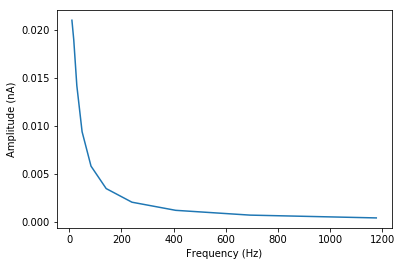

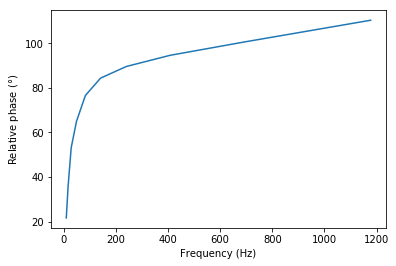

In [177]:
plt.plot(frequencies,ampls)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (nA)')
plt.show()
plt.close()

plt.plot(frequencies,angles)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Relative phase ($\degree$)');